In [2]:
import os
import sys
import json
import argparse

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

from glob import glob
from nilearn import plotting
from nilearn import datasets

from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.image import smooth_img, new_img_like

In [3]:
from nilearn.image import threshold_img
from nilearn import surface
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage()
mni152_template = datasets.load_mni152_template(resolution=1)


In [4]:
task_label = 'tonecat'

project_dir = os.path.join('/bgfs/bchandrasekaran/krs228/data/', 'FLT/')
bidsroot = os.path.join(project_dir,'data_bids')
deriv_dir = os.path.join(project_dir, 'derivatives')

nilearn_dir = os.path.join(bidsroot, 'derivatives', 'nilearn')

## Second-level analyses

Based on [nilearn documentation](https://nilearn.github.io/stable/auto_examples/05_glm_second_level/plot_thresholding.html#statistical-testing-of-a-second-level-analysis)

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [5]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT27']
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [6]:
participants_fpath

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/participants.tsv'

In [7]:
print(participants_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT05   26   M      Mandarin  3010.0
4       sub-FLT06   21   F  non-Mandarin  3001.0
5       sub-FLT07   22   M      Mandarin  2003.0
6       sub-FLT08   23   F      Mandarin  2005.0
7       sub-FLT09   30   F  non-Mandarin  3002.0
8       sub-FLT10   23   F      Mandarin  2006.0
9       sub-FLT11   20   F  non-Mandarin  1005.0
10      sub-FLT12   20   F  non-Mandarin  3004.0
11      sub-FLT13   23   F  non-Mandarin  3005.0
12      sub-FLT14   23   M  non-Mandarin  3006.0
13      sub-FLT15   22   M      Mandarin  2010.0
14      sub-FLT17   29   F      Mandarin     NaN
15      sub-FLT18   24   M      Mandarin  2016.0
16      sub-FLT19   24   M      Mandarin  2018.0
17      sub-FLT20   26   F  non-Mandarin  3008.0
18      sub-FLT21   21   M      Mandarin  2011.0
19      sub-FLT22   

In [8]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [9]:
sub_list_mand

['sub-FLT03',
 'sub-FLT05',
 'sub-FLT07',
 'sub-FLT08',
 'sub-FLT10',
 'sub-FLT15',
 'sub-FLT17',
 'sub-FLT18',
 'sub-FLT19',
 'sub-FLT21',
 'sub-FLT22',
 'sub-FLT23',
 'sub-FLT24',
 'sub-FLT26']

#### Create design matrixes

In [10]:
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )

design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

    Mand  NMan
0      0     1
1      1     0
2      0     1
3      1     0
4      0     1
5      1     0
6      1     0
7      0     1
8      1     0
9      0     1
10     0     1
11     0     1
12     0     1
13     1     0
14     1     0
15     1     0
16     1     0
17     0     1
18     1     0
19     1     0
20     1     0
21     1     0
22     0     1
23     1     0
24     0     1
25     0     1


In [11]:
print(subjects_label)

['sub-FLT02', 'sub-FLT03', 'sub-FLT04', 'sub-FLT05', 'sub-FLT06', 'sub-FLT07', 'sub-FLT08', 'sub-FLT09', 'sub-FLT10', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT15', 'sub-FLT17', 'sub-FLT18', 'sub-FLT19', 'sub-FLT20', 'sub-FLT21', 'sub-FLT22', 'sub-FLT23', 'sub-FLT24', 'sub-FLT25', 'sub-FLT26', 'sub-FLT28', 'sub-FLT30']


### Get files

In [33]:
contrast_label = 'sound'
fwhm = 0.00
searchrad = 5
space_label = 'MNI152NLin2009cAsym'
search_label = 'rsa-searchlight_fwhm-%.02f_searchvox-%d_run-all_LSS'%(fwhm, searchrad)
l1_dir = os.path.join(bidsroot, 'derivatives', 
                      'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l2_dir = os.path.join(bidsroot, 'derivatives', 
                      'nilearn', 'level-2_fwhm-%.02f'%fwhm)
os.makedirs(l2_dir, exist_ok=True)

In [34]:
model_list = ['abs_DSM_PCA_absolute1',  'abs_DSM_PCA_absolute2',  'abs_DSM_PCA_absolute3',
              'rel_DSM_PCA_normalize1', 'rel_DSM_PCA_normalize2', 'rel_DSM_PCA_normalize3', 
              'FFR', 'Tone', 'Talker']

model_label = 'Tone'

In [35]:
for subtest in subjects_label:
    print(l1_dir+'/%s_space-%s/%s/'%(subtest, space_label, search_label)+'%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(subtest, fwhm, searchrad, model_label))

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT02_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT02_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT03_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT04_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT04_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT05_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT05_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz
/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/

In [36]:
l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/%s/'%(sub_id, space_label, search_label) +
                                   '%s_fwhm-%.02f_searchvox-%d_rsa-searchlight_model-%s.nii.gz'%(sub_id, fwhm, searchrad, model_label)))[0] for sub_id in subjects_label]

In [37]:
l1_fnames_groupdiff

['/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT02_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT02_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT03_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT03_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT04_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT04_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-0.00/sub-FLT05_space-MNI152NLin2009cAsym/rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS/sub-FLT05_fwhm-0.00_searchvox-5_rsa-searchlight_model-Tone.nii.gz',
 '/bgfs/bchandrasekaran/krs228/d

## WIP: fisher's r-to-z transformation

### loop through images and transform

In [38]:
diff_img_list = []

for sx, sub_sl_fpath in enumerate(l1_fnames_groupdiff):
    
    sub_sl_img = nib.load(sub_sl_fpath)
    sub_sl_data = sub_sl_img.get_fdata()

    # fisher transform r-to-z
    diff_data = np.arctanh(sub_sl_data)

    diff_img = new_img_like(sub_sl_img, diff_data)

    diff_img_list.append(diff_img)

### Mandarin-speaking participants group RSA

In [39]:
#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

In [40]:
group_label = 'Mand'
out_fname = 'group-{}_{}_model-{}_map-zstat.nii.gz'.format(group_label, search_label, model_label)
out_fpath = os.path.join(l2_dir, out_fname)
nib.save(z_map, out_fpath)

In [41]:
print(out_fpath)

/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-2_fwhm-0.00/group-Mand_rsa-searchlight_fwhm-0.00_searchvox-5_run-all_LSS_model-Tone_map-zstat.nii.gz


In [42]:
from nilearn.image import threshold_img
threshold = 2.58
cthresh = 10
thresholded_map = threshold_img(
                                z_map,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                            )

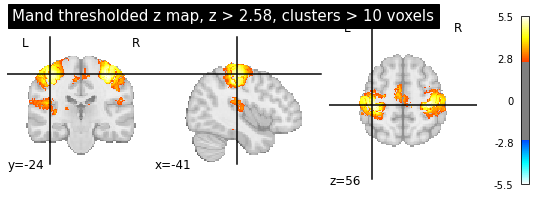

In [43]:
plotting.plot_stat_map(
    thresholded_map, #cut_coords=[17,12,5], 
    threshold=threshold,
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



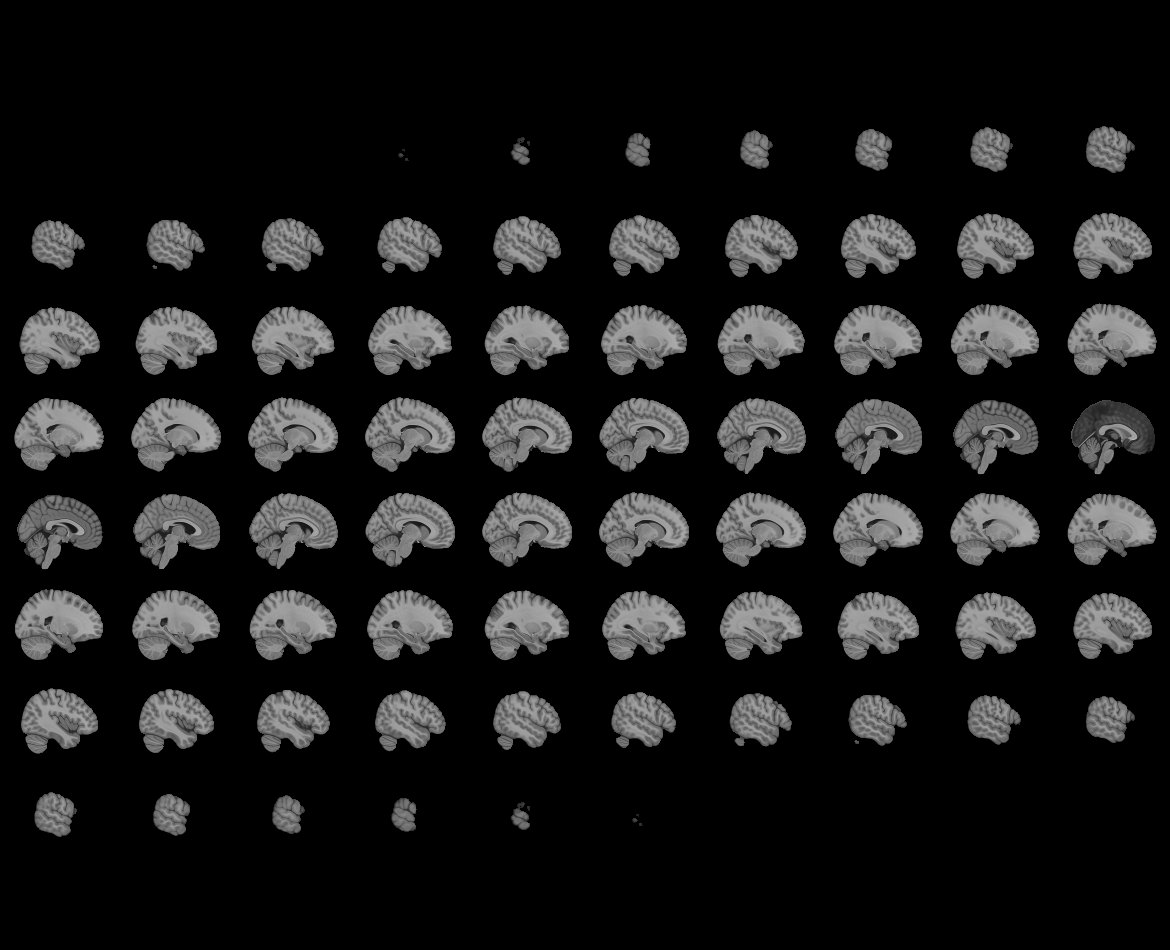
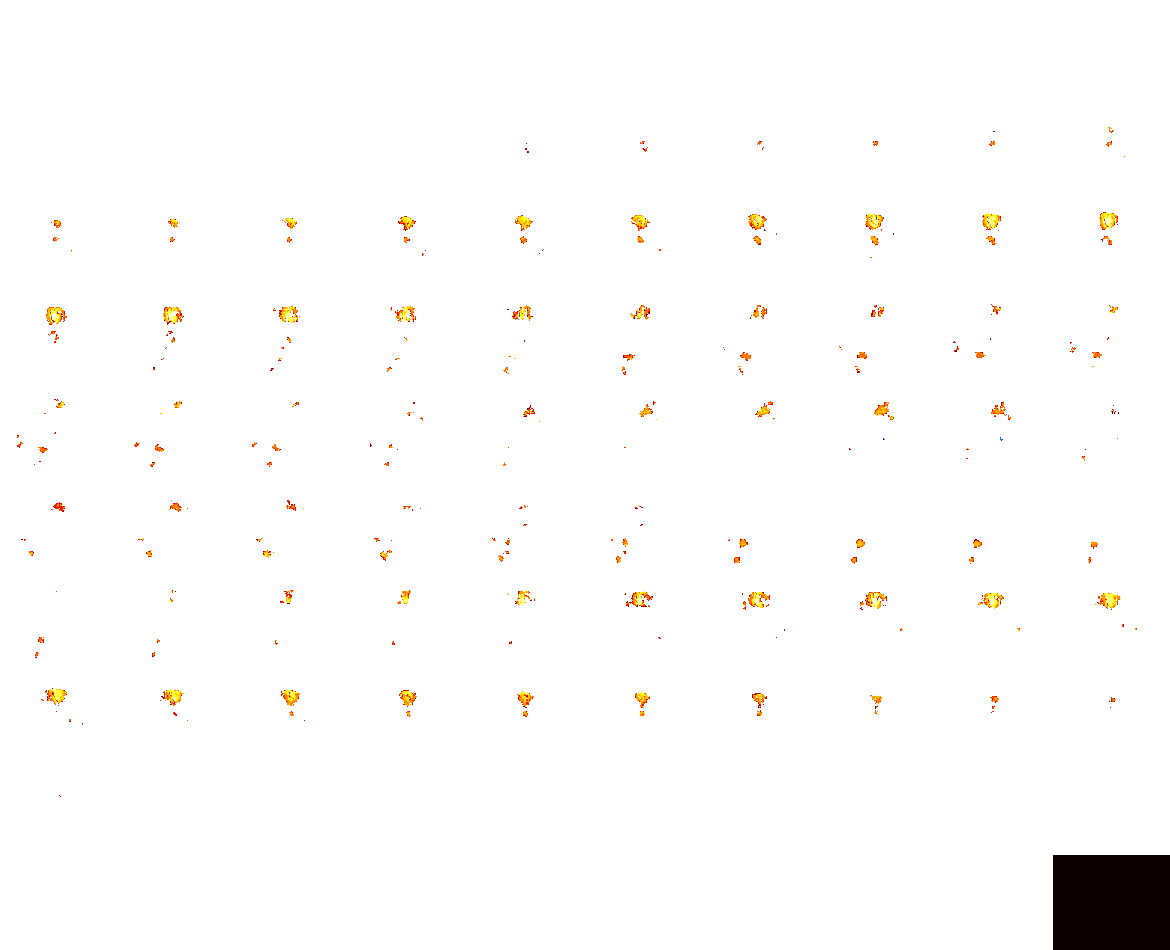

In [44]:
plotting.view_img(thresholded_map,
                  threshold=threshold,
                  symmetric_cmap=True)

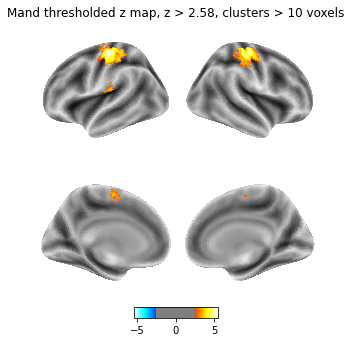

In [45]:
plotting.plot_img_on_surf(thresholded_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=threshold,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

### Non-Mandarin-speaking participants group RSA

In [46]:
#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[0,1,], output_type='z_score')

In [47]:
group_label = 'NMan'
out_fname = 'group-{}_{}_model-{}_map-zstat.nii.gz'.format(group_label, search_label, model_label)
out_fpath = os.path.join(l2_dir, out_fname)
nib.save(z_map, out_fpath)

In [48]:
threshold = 2.58
cthresh = 10
thresholded_map = threshold_img(
                                z_map,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                            )

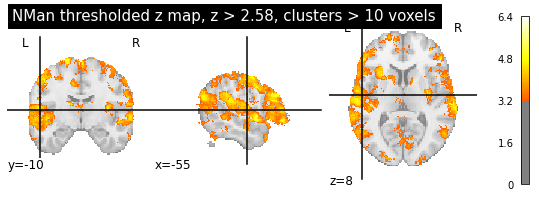

In [54]:
plotting.plot_stat_map(
    thresholded_map, #cut_coords=[17,12,5], 
    threshold=1.25*threshold,
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



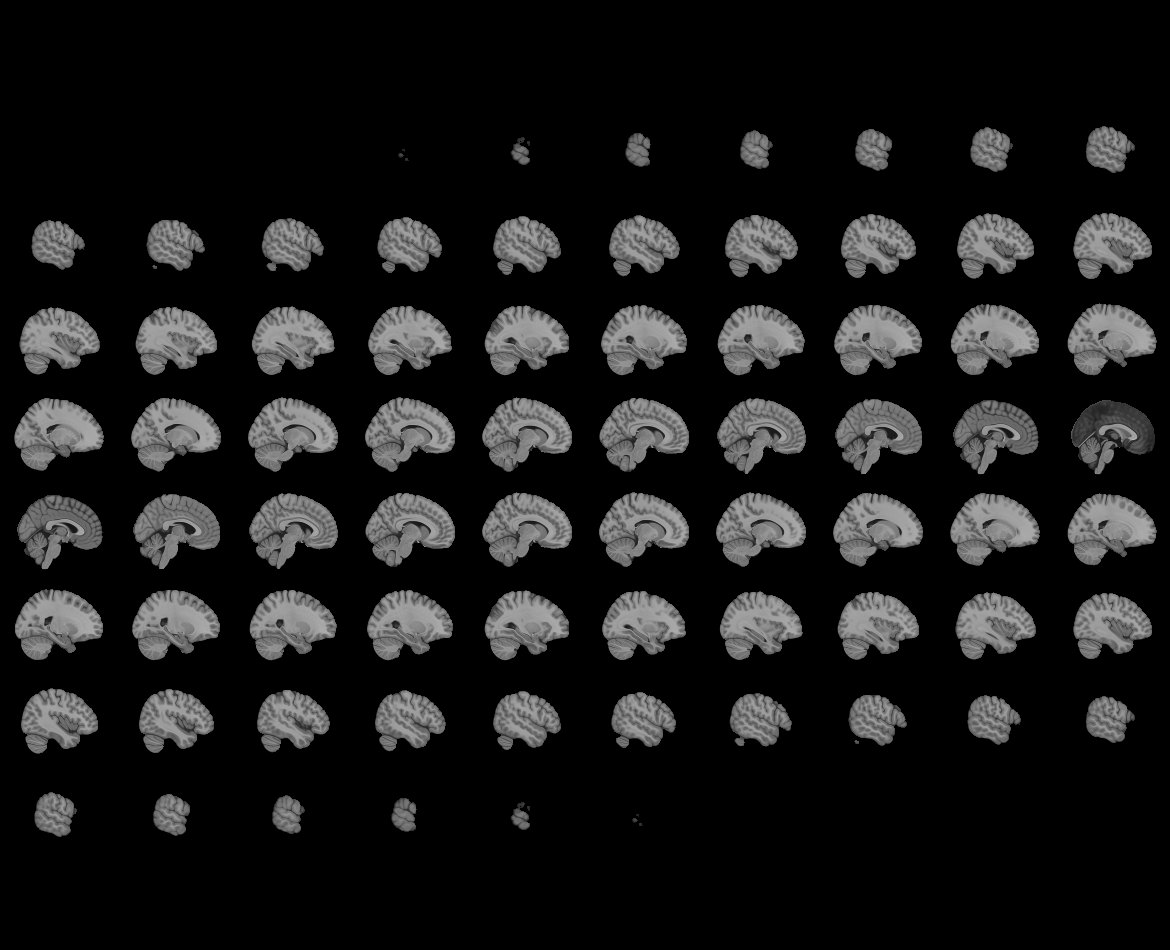
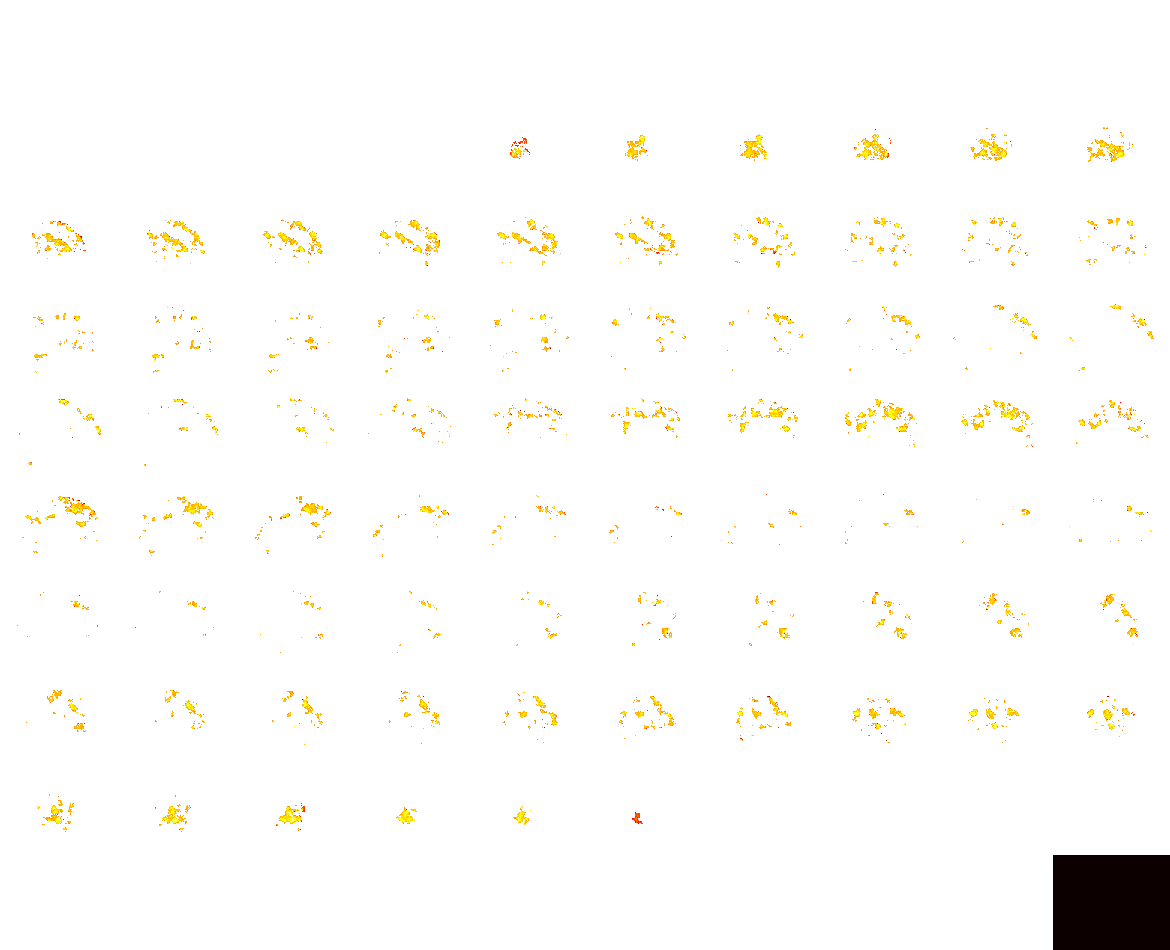

In [50]:
plotting.view_img(thresholded_map,
                  threshold=1.5*threshold,
                  symmetric_cmap=True)

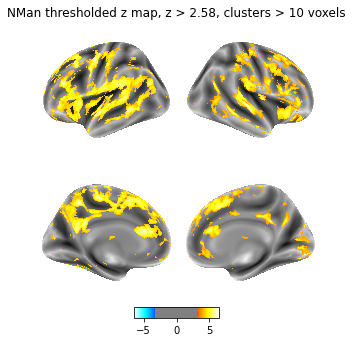

In [53]:
plotting.plot_img_on_surf(thresholded_map,
                          surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=1.25*threshold,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

#### Group differences in RSA searchlight

In [52]:
#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)
z_map_diff = second_level_model.compute_contrast(second_level_contrast=[1, -1,], output_type='z_score')

In [55]:
for model_label in model_list:
    print(model_label)
    l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/%s/'%(sub_id, space_label, search_label) +
                                   '%s_rsa-searchlight_model-%s.nii.gz'%(sub_id, model_label)))[0] for sub_id in subjects_label]
    
    diff_img_list = []
    for sx, sub_sl_fpath in enumerate(l1_fnames_groupdiff):

        sub_sl_img = nib.load(sub_sl_fpath)
        sub_sl_data = sub_sl_img.get_fdata()

        # fisher transform r-to-z
        diff_data = np.arctanh(sub_sl_data)
        diff_img = new_img_like(sub_sl_img, diff_data)
        diff_img_list.append(diff_img)

    second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)
    z_map_diff = second_level_model.compute_contrast(second_level_contrast=[1, -1,], output_type='z_score')

    group_label = 'diff-Mand-gt-NMan'
    out_fname = 'group-{}_{}_model-{}_map-zstat.nii.gz'.format(group_label, search_label, model_label) 
    out_fpath = os.path.join(l2_dir, out_fname)
    nib.save(z_map_diff, out_fpath)

abs_DSM_PCA_absolute1


IndexError: list index out of range

In [234]:
threshold = 2.58
cthresh = 10
thresh_diff_map = threshold_img(
                                z_map_diff,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                            )

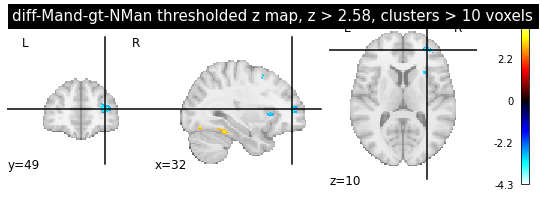

In [235]:
plotting.plot_stat_map(
    thresh_diff_map, 
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



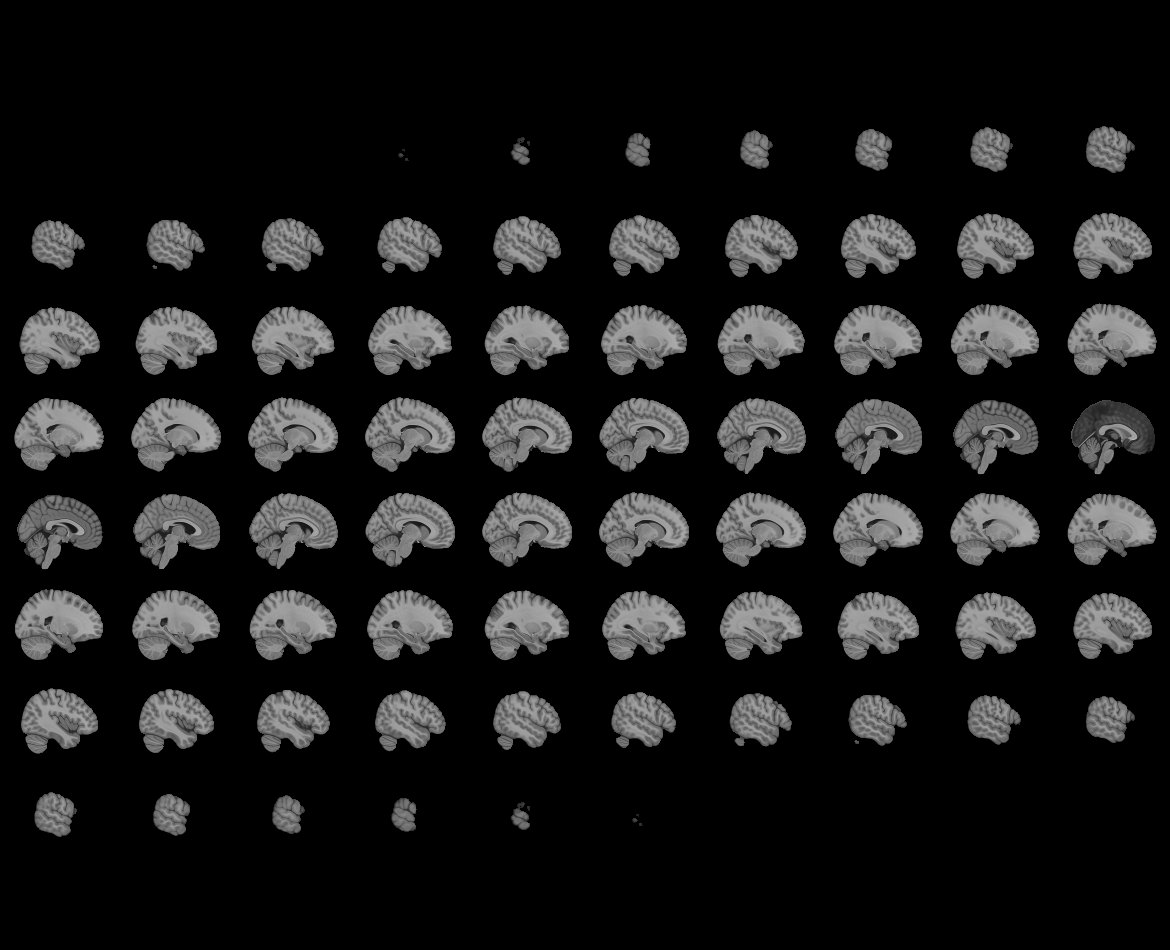
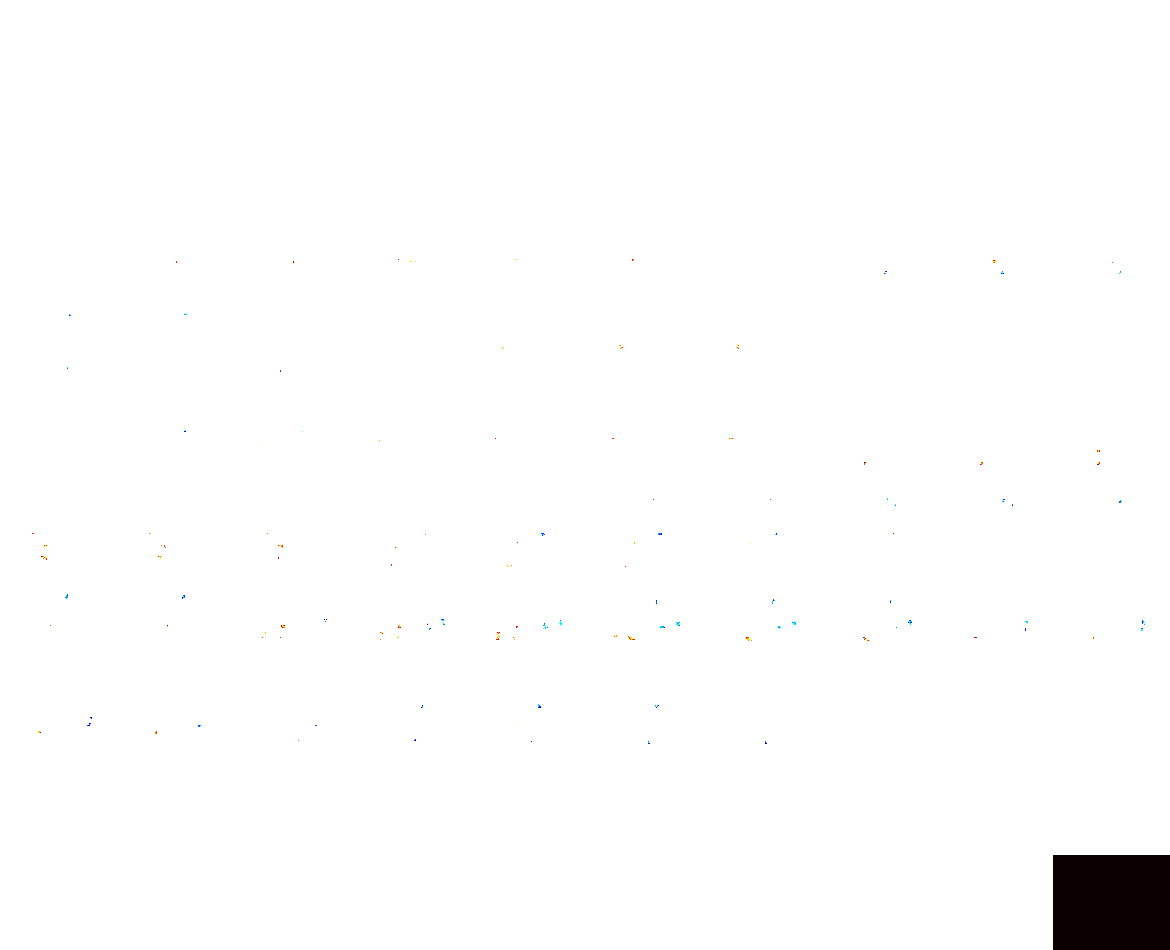

In [236]:
plotting.view_img(thresh_diff_map,
                  threshold=threshold,
                  symmetric_cmap=True)

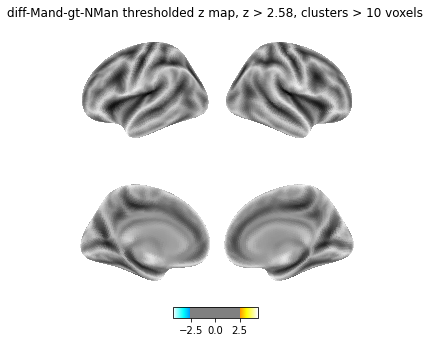

In [238]:
plotting.plot_img_on_surf(thresh_diff_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=threshold,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

## loop over all images and save

In [ ]:
for group_label in ['Mand', 'NMan', 'diff-Mand-gt-NMan']: #
    for model_label in model_list:
        img_fname = 'group-{}_rsa-searchlight_model-{}_map-zstat.nii.gz'.format(group_label, model_label)
        img_fpath = os.path.join(l2_dir, img_fname)

        fig_fpath = os.path.join('level-2_out', 
                                 'group-{}_rsa-searchlight_model-{}_map-zstat.png'.format(group_label, 
                                                                                          model_label))
        title='group-%s model-%s\nz > %.02f – clusters > %d voxels'%(group_label, model_label, threshold, cthresh)
        threshold = 2.58
        cthresh = 10
        thresholded_map = threshold_img(
                                        img_fpath,
                                        threshold=threshold,
                                        cluster_threshold=cthresh,
                                        two_sided=True,
                                    )
        #fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5,4), dpi=500)
        fig, ax = plotting.plot_img_on_surf(thresholded_map,
                                  surf_mesh='fsaverage',
                                  views=['lateral', 'medial'],
                                  hemispheres=['left', 'right'],
                                  inflate=True,
                                  threshold=threshold,
                                  colorbar=True,
                                  title=title,
                                  #kwargs={'figure':fig, 'axes':ax}
                                 )
        fig.savefig(fig_fpath)
        print('file saved to ', fig_fpath)

In [ ]:
threshold = 2.58
cthresh = 10
    
for group_label in ['Mand', 'NMan', 'diff-Mand-gt-NMan']: # 'Mand', 'NMan', 'diff-Mand-gt-NMan'
    for model_label in model_list:
        title='group-%s model-%s \n z > %.02f – clusters > %d voxels'%(group_label, model_label, threshold, cthresh)
        
        #fig = plt.figure(constrained_layout=True, figsize=(8,4), dpi=500)
        #subfigs = fig.subfigures(nrows=3, ncols=1)
        fig, axes = plt.subplots(3, 1, figsize=(6,3), dpi=500)
        fig.suptitle(title)
        
        img_fname = 'group-{}_rsa-searchlight_model-{}_map-zstat.nii.gz'.format(group_label, model_label)
        img_fpath = os.path.join(l2_dir, img_fname)

        fig_fpath = os.path.join('level-2_out', 
                                 'group-{}_rsa-searchlight_model-{}_map-zstat_slice.png'.format(group_label, 
                                                                                          model_label))
        thresholded_map = threshold_img(
                                        img_fpath,
                                        threshold=threshold,
                                        cluster_threshold=cthresh,
                                        two_sided=True,
                                    )

        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               display_mode='x',
                               cut_coords=[-60, -45, -30, -15, 0, 15, 30, 45, 60],
                               colorbar=False,
                               annotate=False,
                               #title=title,
                               figure=fig, 
                               axes=axes[0])
        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               display_mode='y',
                               cut_coords=[-100, -80, -60, -40, -20, 0, 20, 40, 60],
                               colorbar=False,
                               annotate=False,
                               #title=title,
                               figure=fig, 
                               axes=axes[1])
        plotting.plot_stat_map(thresholded_map, 
                               bg_img=mni152_template, 
                               black_bg=False,
                               display_mode='z',
                               cut_coords=[-50, -35, -20, -5, 10, 25, 40, 55, 70],
                               colorbar=False,
                               annotate=False,
                               #title=title,
                               #figure=fig, 
                               axes=axes[2])
        
        fig.savefig(fig_fpath)
        print('file saved to ', fig_fpath)

# Participant-specific FFR

### Build the group-level design matrix

#### Read the `participants.tsv` file from the BIDS root directory

In [150]:
participants_fpath = os.path.join(bidsroot, 'participants.tsv')
participants_df = pd.read_csv(participants_fpath, sep='\t')

# subjects to ignore (not fully processed, etc.)
ignore_subs = ['sub-FLT05', 'sub-FLT08', 'sub-FLT09', 
               'sub-FLT16', 'sub-FLT17', 'sub-FLT18', 'sub-FLT19', 
               'sub-FLT20', 'sub-FLT22', 'sub-FLT23', 'sub-FLT26', 
               'sub-FLT27', 'sub-FLT30']
participants_df.drop(participants_df[participants_df.participant_id.isin(ignore_subs)].index,
                     inplace=True)

# re-sort by participant ID
participants_df.sort_values(by=['participant_id'], 
                            ignore_index=True, 
                            inplace=True)

In [151]:
participants_fpath

'/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/participants.tsv'

In [152]:
print(participants_df)

   participant_id  age sex         group  FFR_id
0       sub-FLT02   21   F  non-Mandarin  1002.0
1       sub-FLT03   25   F      Mandarin  2002.0
2       sub-FLT04   21   F  non-Mandarin  1003.0
3       sub-FLT06   21   F  non-Mandarin  3001.0
4       sub-FLT07   22   M      Mandarin  2003.0
5       sub-FLT10   23   F      Mandarin  2006.0
6       sub-FLT11   20   F  non-Mandarin  1005.0
7       sub-FLT12   20   F  non-Mandarin  3004.0
8       sub-FLT13   23   F  non-Mandarin  3005.0
9       sub-FLT14   23   M  non-Mandarin  3006.0
10      sub-FLT15   22   M      Mandarin  2010.0
11      sub-FLT21   21   M      Mandarin  2011.0
12      sub-FLT24   20   M      Mandarin  2015.0
13      sub-FLT25   19   F  non-Mandarin  2015.0


In [153]:
# create group-specific lists of subject IDs
sub_list_mand = list(participants_df.participant_id[participants_df.group=='Mandarin'])
sub_list_nman = list(participants_df.participant_id[participants_df.group=='non-Mandarin'])

In [154]:
sub_list_mand

['sub-FLT03', 'sub-FLT07', 'sub-FLT10', 'sub-FLT15', 'sub-FLT21', 'sub-FLT24']

#### Create design matrixes

In [155]:
# difference between groups
subjects_label = list(participants_df.participant_id)
groups_label = list(participants_df.group)
design_mat_groupdiff = pd.DataFrame({'Mand': groups_label,
                                     'NMan': groups_label,
                                    }
                                   )

design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'Mandarin'] = 1
design_mat_groupdiff['Mand'].loc[design_mat_groupdiff['Mand'] == 'non-Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'Mandarin'] = 0
design_mat_groupdiff['NMan'].loc[design_mat_groupdiff['NMan'] == 'non-Mandarin'] = 1
design_mat_groupdiff = design_mat_groupdiff.astype('int')
print(design_mat_groupdiff)

    Mand  NMan
0      0     1
1      1     0
2      0     1
3      0     1
4      1     0
5      1     0
6      0     1
7      0     1
8      0     1
9      0     1
10     1     0
11     1     0
12     1     0
13     0     1


In [156]:
print(subjects_label)

['sub-FLT02', 'sub-FLT03', 'sub-FLT04', 'sub-FLT06', 'sub-FLT07', 'sub-FLT10', 'sub-FLT11', 'sub-FLT12', 'sub-FLT13', 'sub-FLT14', 'sub-FLT15', 'sub-FLT21', 'sub-FLT24', 'sub-FLT25']


## single-run version

### Get files

In [11]:
contrast_label = 'sound'
fwhm = 1.5
space_label = 'MNI152NLin2009cAsym'
l1_dir = os.path.join(bidsroot, 'derivatives', 
                      'nilearn', 'level-1_fwhm-%.02f'%fwhm)
l2_dir = os.path.join(bidsroot, 'derivatives', 
                      'nilearn', 'level-2_fwhm-%.02f'%fwhm)

In [157]:
model_list = ['abs_DSM_PCA_absolute1',  'abs_DSM_PCA_absolute2',  'abs_DSM_PCA_absolute3',
              'rel_DSM_PCA_normalize1', 'rel_DSM_PCA_normalize2', 'rel_DSM_PCA_normalize3', 
              'FFR_participant', 'Tone', 'Talker']

model_label = 'FFR_participant'

In [177]:
ls $l1_dir/sub-FLT02_space-MNI152NLin2009cAsym/rsa-searchlight_run-all_LSS/

sub-FLT02_rsa-searchlight_model-abs_DSM_PCA_absolute1.nii.gz
sub-FLT02_rsa-searchlight_model-abs_DSM_PCA_absolute2.nii.gz
sub-FLT02_rsa-searchlight_model-abs_DSM_PCA_absolute3.nii.gz
sub-FLT02_rsa-searchlight_model-FFR.nii.gz
sub-FLT02_rsa-searchlight_model-FFR_participant.nii.gz
sub-FLT02_rsa-searchlight_model-rel_DSM_PCA_normalize1.nii.gz
sub-FLT02_rsa-searchlight_model-rel_DSM_PCA_normalize2.nii.gz
sub-FLT02_rsa-searchlight_model-rel_DSM_PCA_normalize3.nii.gz
sub-FLT02_rsa-searchlight_model-Talker.nii.gz
sub-FLT02_rsa-searchlight_model-Tone.nii.gz


In [178]:
run_label = 'run-all'
search_label = f'rsa-searchlight_{run_label}_LSS' 


In [179]:
l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/%s/'%(sub_id, space_label, search_label) +
                                   '%s_rsa-searchlight_model-%s.nii.gz'%(sub_id, model_label)))[0] for sub_id in subjects_label]

In [180]:
l1_fnames_groupdiff

['/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT02_space-MNI152NLin2009cAsym/rsa-searchlight_run-all_LSS/sub-FLT02_rsa-searchlight_model-FFR_participant.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT03_space-MNI152NLin2009cAsym/rsa-searchlight_run-all_LSS/sub-FLT03_rsa-searchlight_model-FFR_participant.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT04_space-MNI152NLin2009cAsym/rsa-searchlight_run-all_LSS/sub-FLT04_rsa-searchlight_model-FFR_participant.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT06_space-MNI152NLin2009cAsym/rsa-searchlight_run-all_LSS/sub-FLT06_rsa-searchlight_model-FFR_participant.nii.gz',
 '/bgfs/bchandrasekaran/krs228/data/FLT/data_bids/derivatives/nilearn/level-1_fwhm-1.50/sub-FLT07_space-MNI152NLin2009cAsym/rsa-searchlight_run-all_LSS/sub-FLT07_rs

## WIP: fisher's r-to-z transformation

### loop through images and transform

In [181]:
diff_img_list = []

for sx, sub_sl_fpath in enumerate(l1_fnames_groupdiff):
    
    sub_sl_img = nib.load(sub_sl_fpath)
    sub_sl_data = sub_sl_img.get_fdata()

    # fisher transform r-to-z
    diff_data = np.arctanh(sub_sl_data)

    diff_img = new_img_like(sub_sl_img, diff_data)

    diff_img_list.append(diff_img)

### Mandarin-speaking participants group RSA

In [182]:
#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[1, 0,], output_type='z_score')

In [183]:
group_label = 'Mand'
out_fname = 'group-{}_rsa-searchlight_{}_model-{}_map-zstat.nii.gz'.format(group_label, run_label, model_label)
out_fpath = os.path.join(l2_dir, out_fname)
nib.save(z_map, out_fpath)

In [184]:
threshold = 2
cthresh = 10
thresholded_map = threshold_img(
                                z_map,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                            )

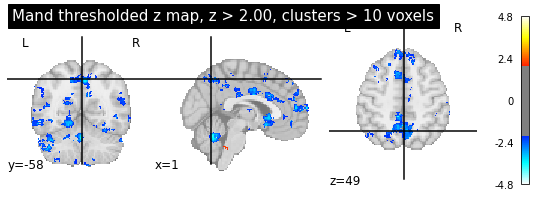

In [185]:
plotting.plot_stat_map(
    thresholded_map, #cut_coords=[17,12,5], 
    threshold=threshold,
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



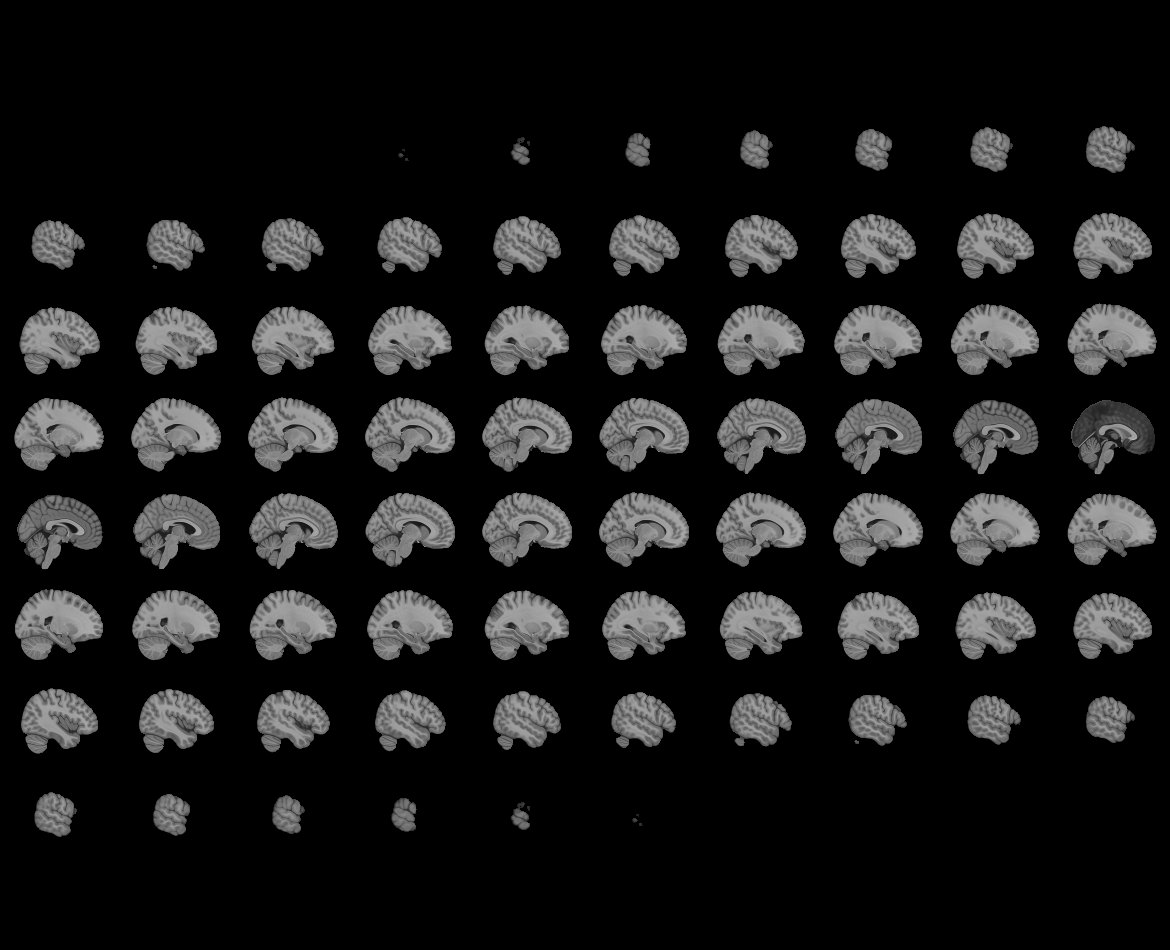
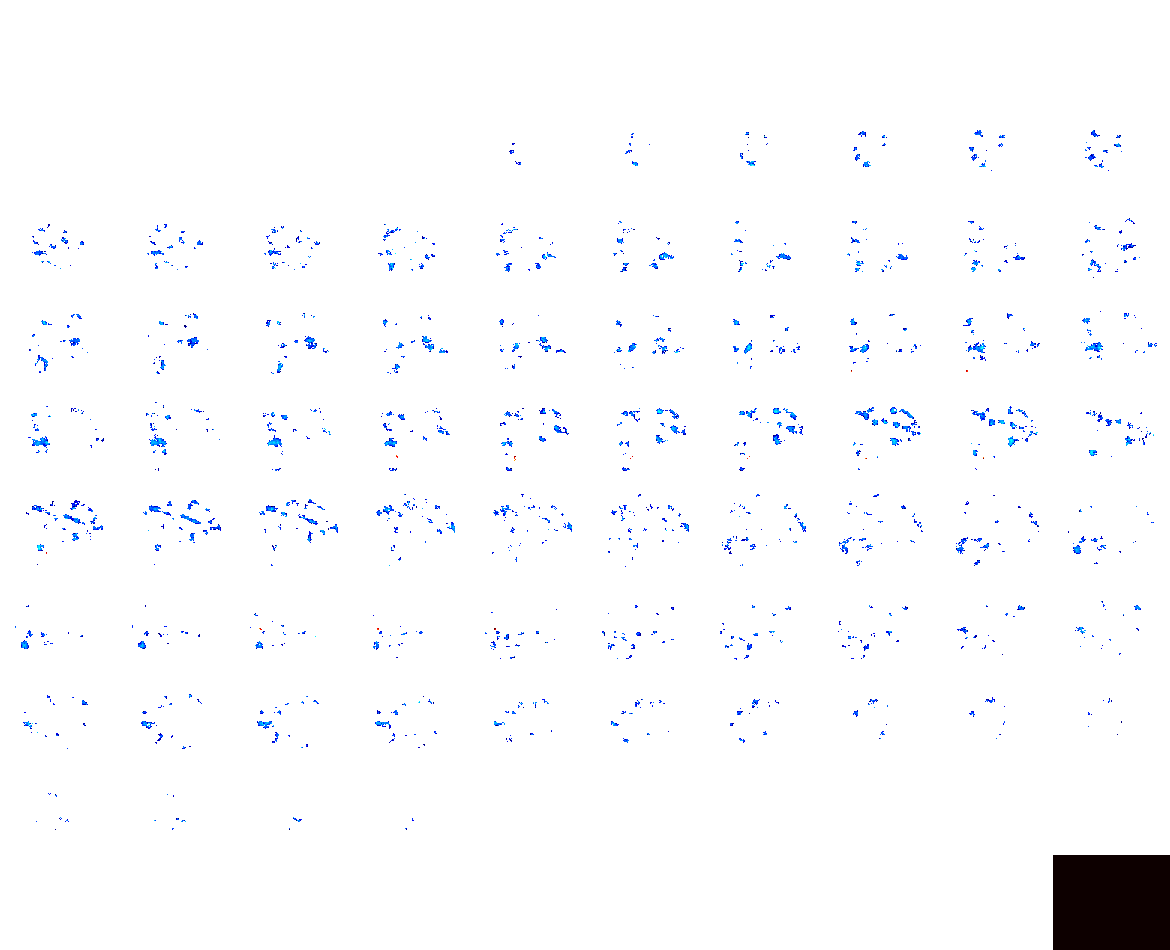

In [186]:
plotting.view_img(thresholded_map,
                  threshold=threshold,
                  symmetric_cmap=True)

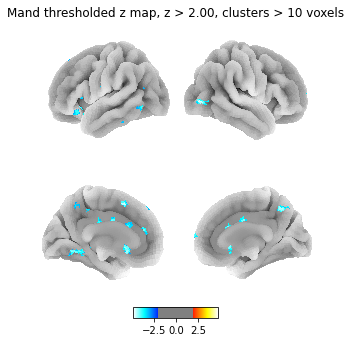

In [187]:
plotting.plot_img_on_surf(thresholded_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          threshold=threshold,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

### Non-Mandarin-speaking participants group RSA

In [188]:
#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)

z_map = second_level_model.compute_contrast(second_level_contrast=[0,1,], output_type='z_score')

In [189]:
group_label = 'NMan'
out_fname = 'group-{}_rsa-searchlight_{}_model-{}_map-zstat.nii.gz'.format(group_label, run_label, model_label)
out_fpath = os.path.join(l2_dir, out_fname)
nib.save(z_map, out_fpath)

In [190]:
threshold = 2
cthresh = 10
thresholded_map = threshold_img(
                                z_map,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                            )

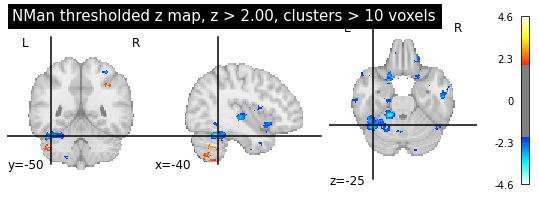

In [191]:
plotting.plot_stat_map(
    thresholded_map, #cut_coords=[17,12,5], 
    threshold=threshold,
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



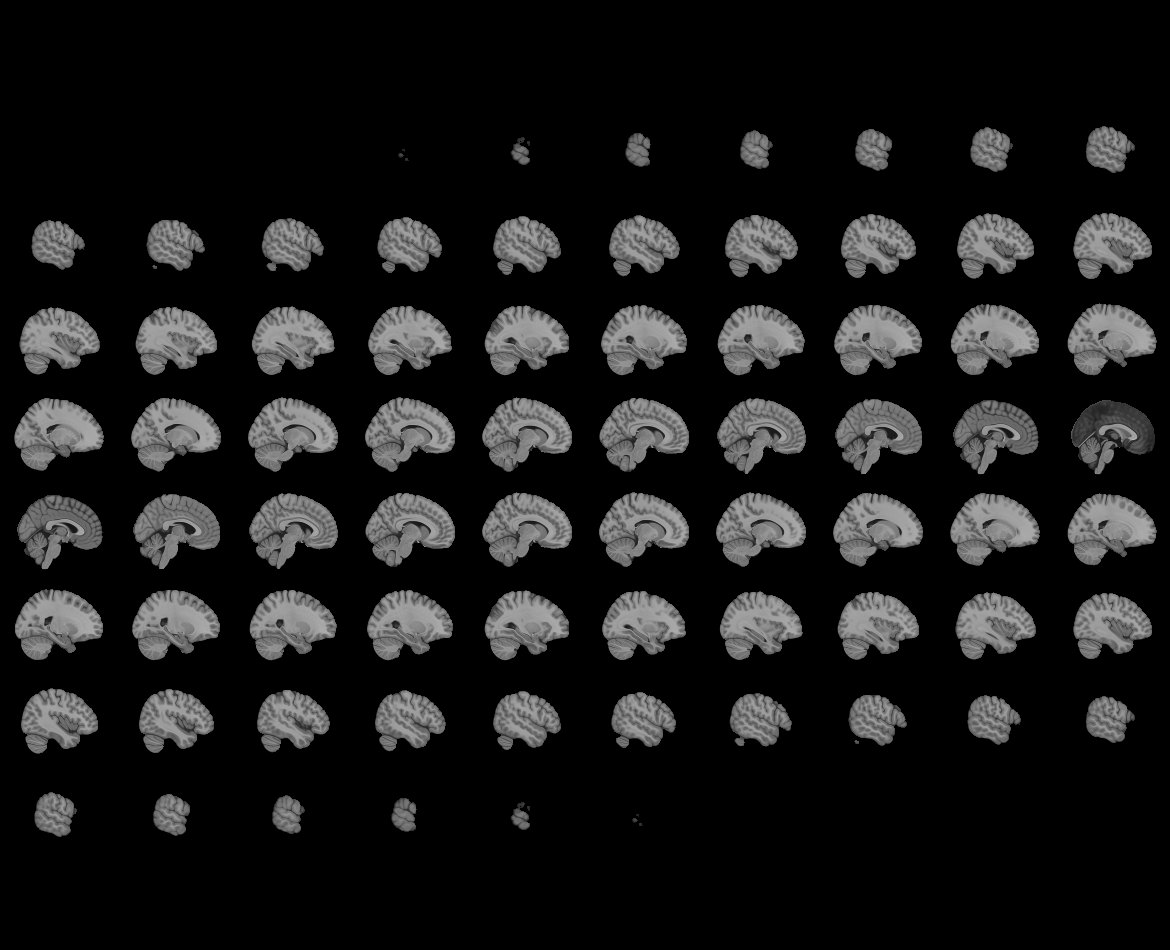
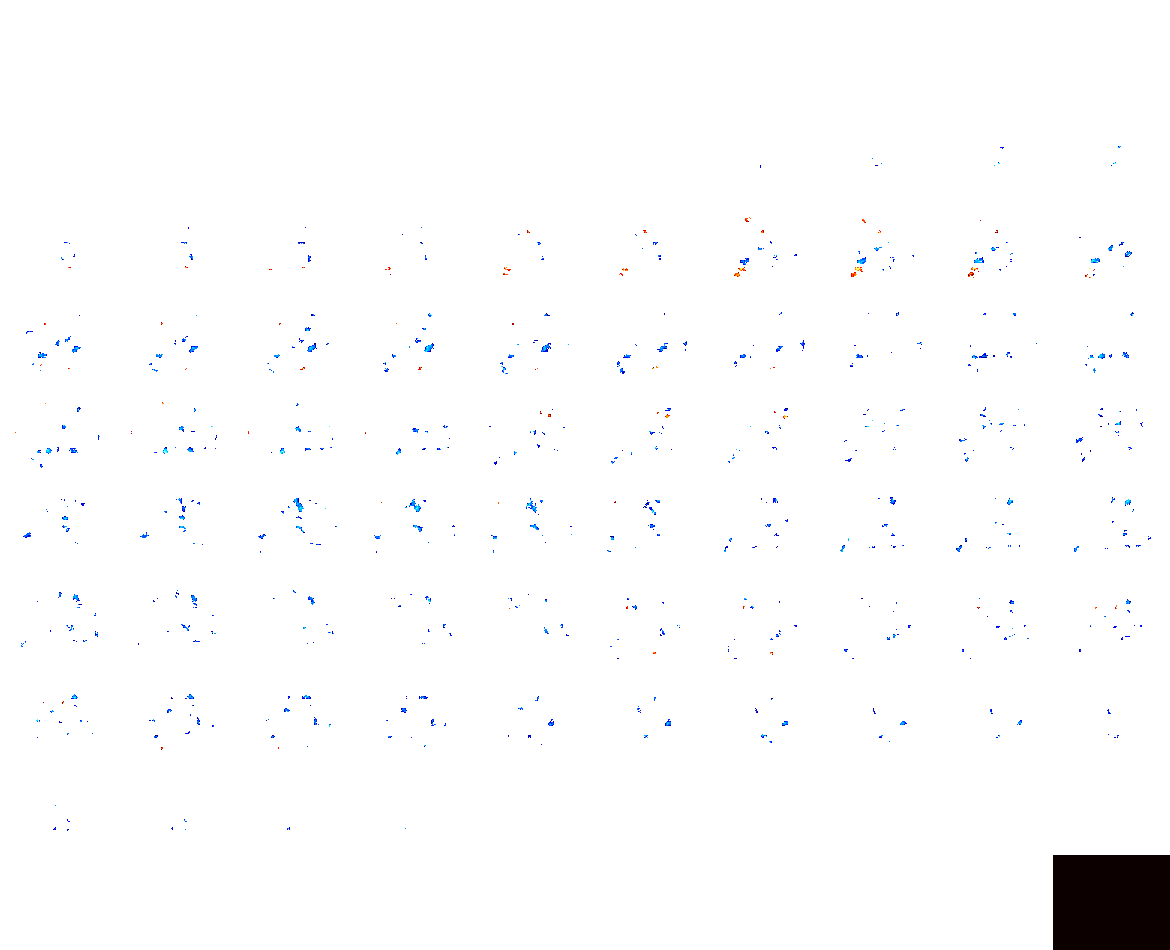

In [192]:
plotting.view_img(thresholded_map,
                  threshold=threshold,
                  symmetric_cmap=True)

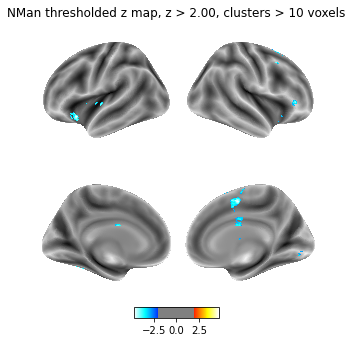

In [193]:
plotting.plot_img_on_surf(thresholded_map,
                          surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=threshold,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()

#### Group differences in RSA searchlight

In [194]:
#second_level_model = SecondLevelModel().fit(smoothed_l1_fnames_groupdiff, design_matrix=design_mat_groupdiff)
second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)
z_map_diff = second_level_model.compute_contrast(second_level_contrast=[1, -1,], output_type='z_score')

In [195]:
'''
for model_label in model_list:
    print(model_label)
    l1_fnames_groupdiff = [sorted(glob(l1_dir+'/%s_space-%s/%s/'%(sub_id, space_label, search_label) +
                                   '%s_rsa-searchlight_model-%s.nii.gz'%(sub_id, model_label)))[0] for sub_id in subjects_label]
    
    diff_img_list = []
    for sx, sub_sl_fpath in enumerate(l1_fnames_groupdiff):

        sub_sl_img = nib.load(sub_sl_fpath)
        sub_sl_data = sub_sl_img.get_fdata()

        # fisher transform r-to-z
        diff_data = np.arctanh(sub_sl_data)
        diff_img = new_img_like(sub_sl_img, diff_data)
        diff_img_list.append(diff_img)
'''

second_level_model = SecondLevelModel().fit(diff_img_list, design_matrix=design_mat_groupdiff)
z_map_diff = second_level_model.compute_contrast(second_level_contrast=[1, -1,], output_type='z_score')

group_label = 'diff-Mand-gt-NMan'
out_fname = 'group-{}_rsa-searchlight_{}_model-{}_map-zstat.nii.gz'.format(group_label, run_label, model_label)
out_fpath = os.path.join(l2_dir, out_fname)
nib.save(z_map_diff, out_fpath)

In [196]:
threshold = 2
cthresh = 10
thresh_diff_map = threshold_img(
                                z_map_diff,
                                threshold=threshold,
                                cluster_threshold=cthresh,
                                two_sided=True,
                            )

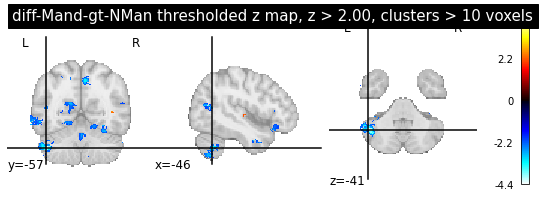

In [197]:
plotting.plot_stat_map(
    thresh_diff_map, 
    title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))

/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/bgfs/bchandrasekaran/krs228/software/miniconda3/envs/py3/lib/python3.9/site-packages/nilearn/plotting/html_document.py:59: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  warnings.warn('It seems you have created more than {} '



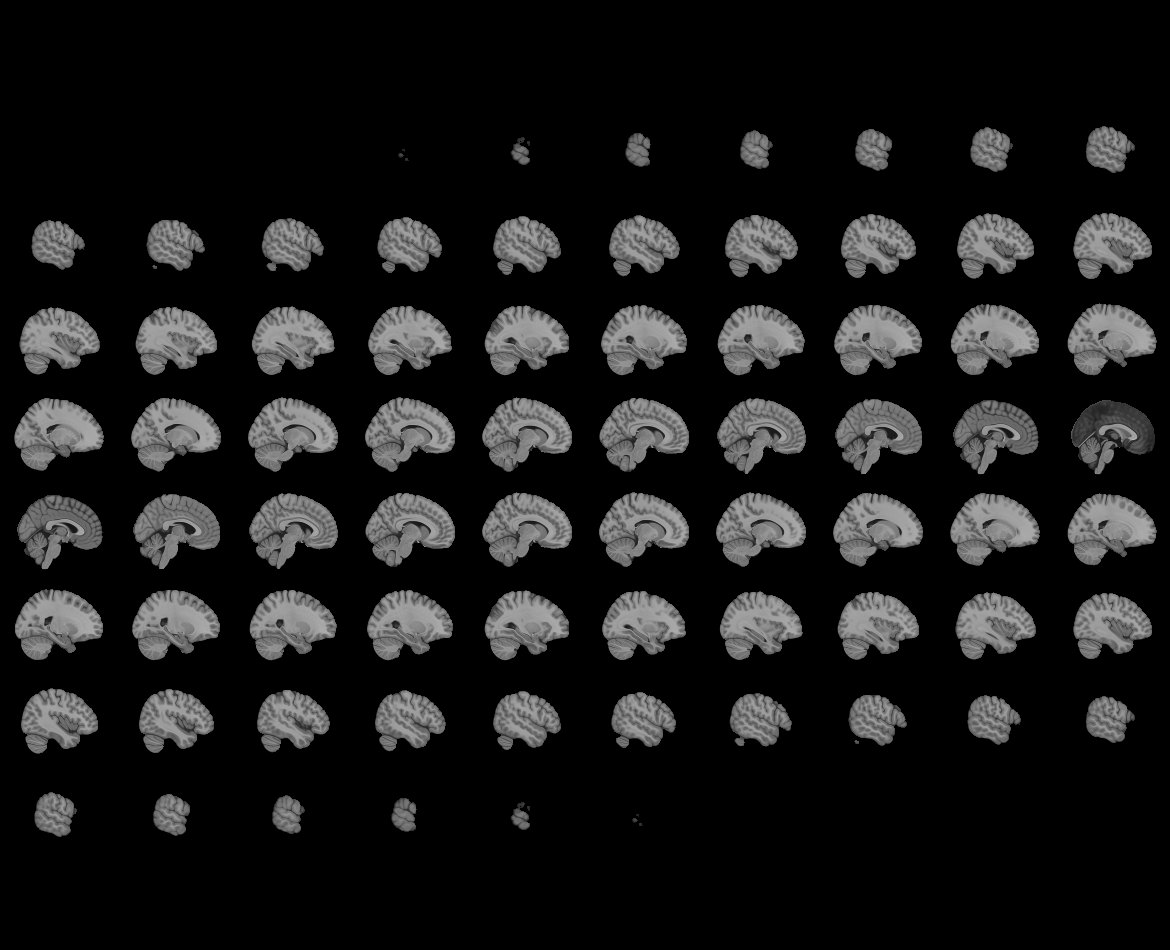
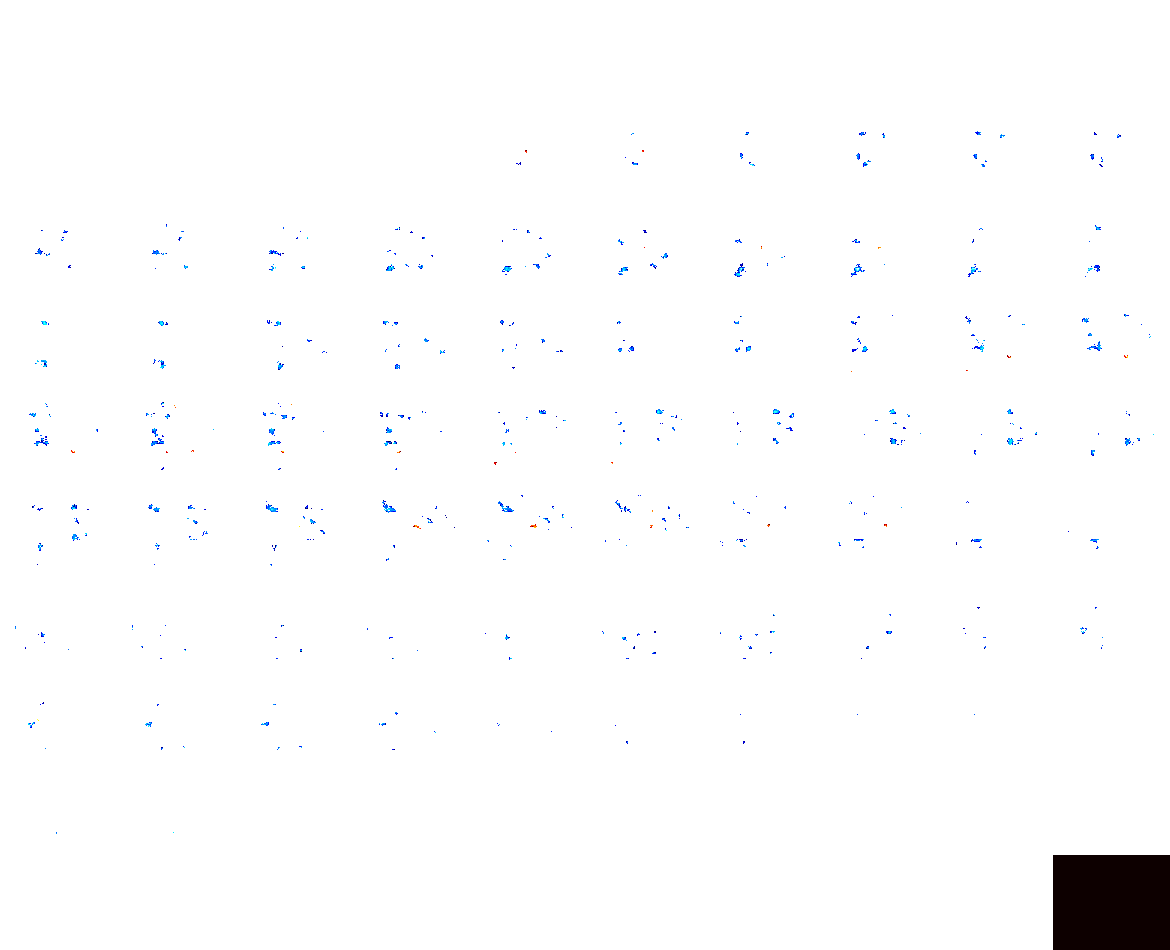

In [198]:
plotting.view_img(thresh_diff_map,
                  threshold=threshold,
                  symmetric_cmap=True)

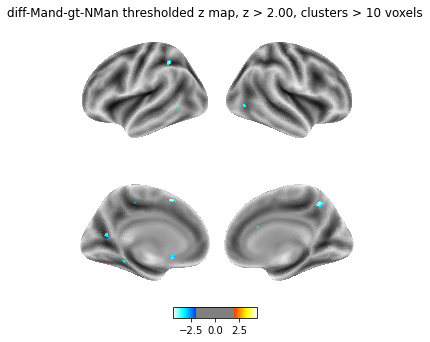

In [199]:
plotting.plot_img_on_surf(thresh_diff_map,
                          #surf_mesh='fsaverage', # comment out for faster default (fsaverage5)
                          views=['lateral', 'medial'],
                          hemispheres=['left', 'right'],
                          inflate=True,
                          threshold=threshold,
                          #cmap='Reds',
                          colorbar=True,
                          title='%s thresholded z map, z > %.02f, clusters > %d voxels'%(group_label, threshold, cthresh))
plotting.show()